In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import sklearn
import tqdm.notebook as tqdm

import scipy
import networkx as nx

sns.set_style("whitegrid")

In [3]:
!ls

 GNN	       probs_cohort0	'Sensitivity Analysis - AUC_PRC Curves.ipynb'
 LASSO.ipynb   probs_cohort1
 MLP.ipynb     probs_cohortall


In [5]:
!ls probs_cohort0

frax_all.npy  GAUSS_GAT.npy  KNN_GAT.npy  Y_GAUSS_GAT.npy  Y_KNN_GAT.npy
frax_Y.npy    GAUSS_GNN.npy  KNN_GNN.npy  Y_GAUSS_GNN.npy  Y_KNN_GNN.npy


In [19]:
folder_to_analyze = "probs_cohortall"

Detected model files:
KNN_GAT: {'pred': 'probs_cohortall/KNN_GAT.npy', 'label': 'probs_cohortall/Y_KNN_GAT.npy'}
KNN_SAGE: {'pred': 'probs_cohortall/KNN_SAGE.npy', 'label': 'probs_cohortall/Y_KNN_SAGE.npy'}
frax: {'label': 'probs_cohortall/frax_Y.npy', 'pred': 'probs_cohortall/frax_all.npy'}


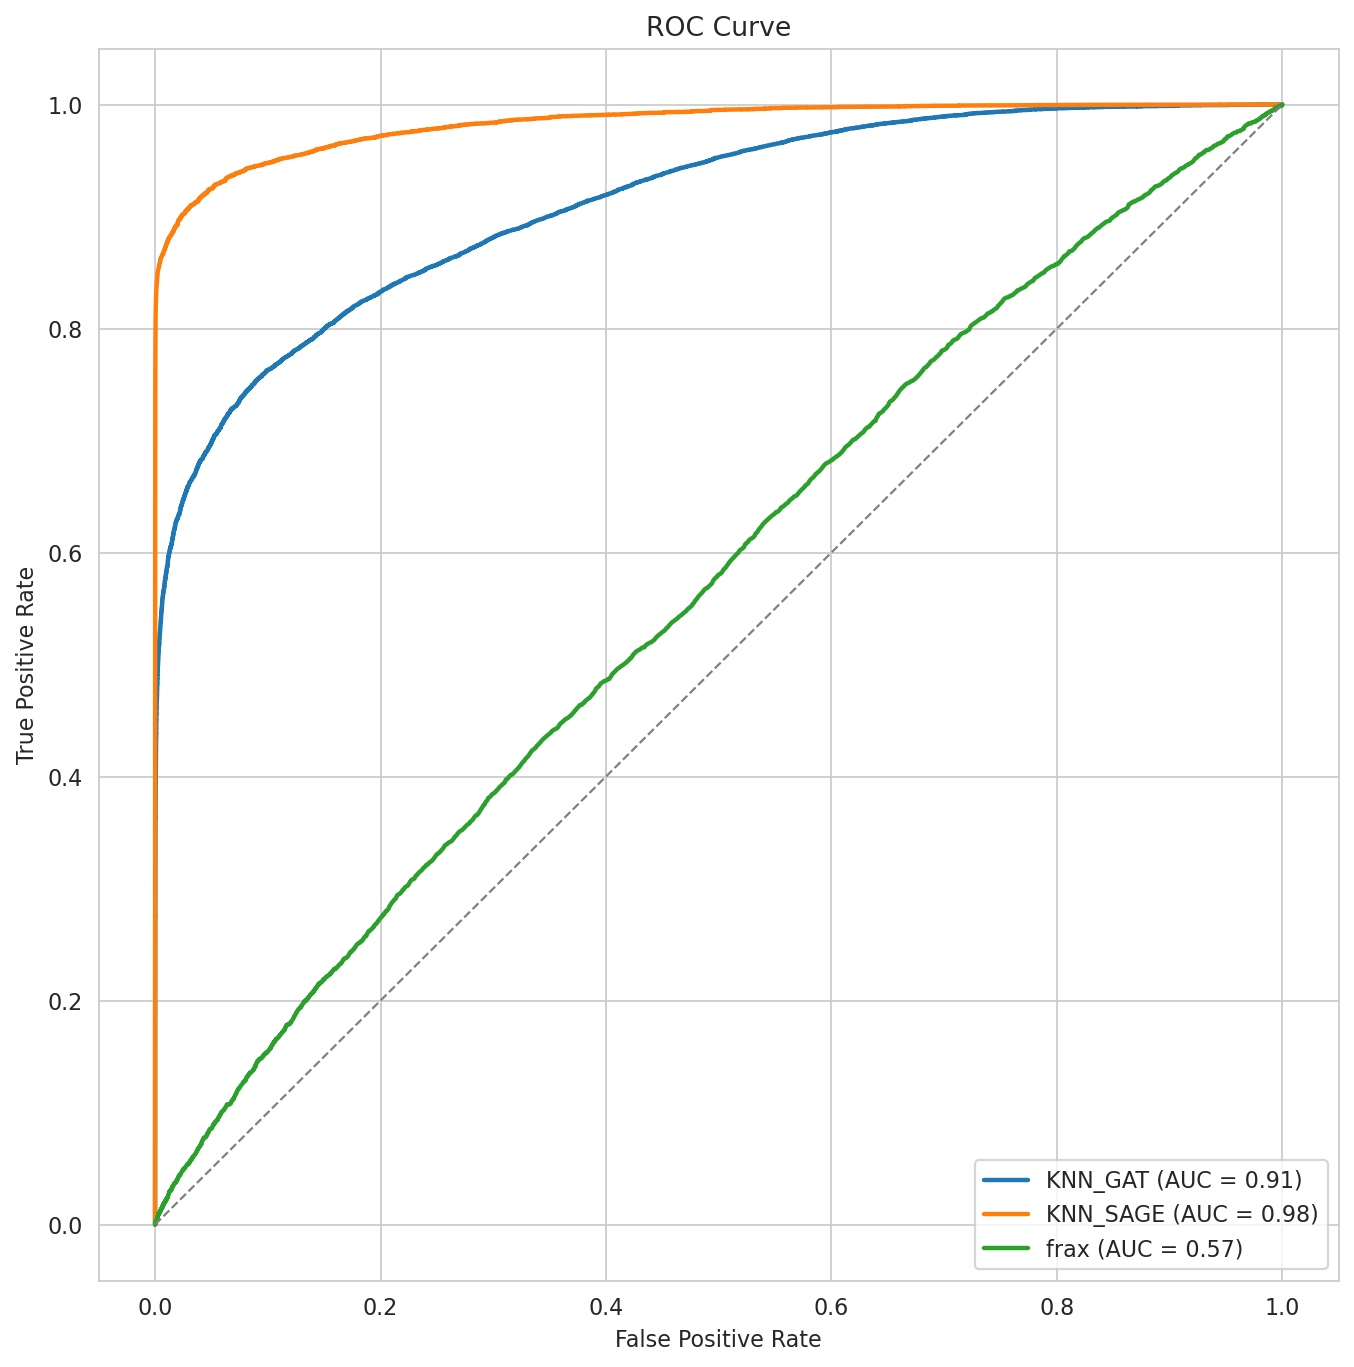

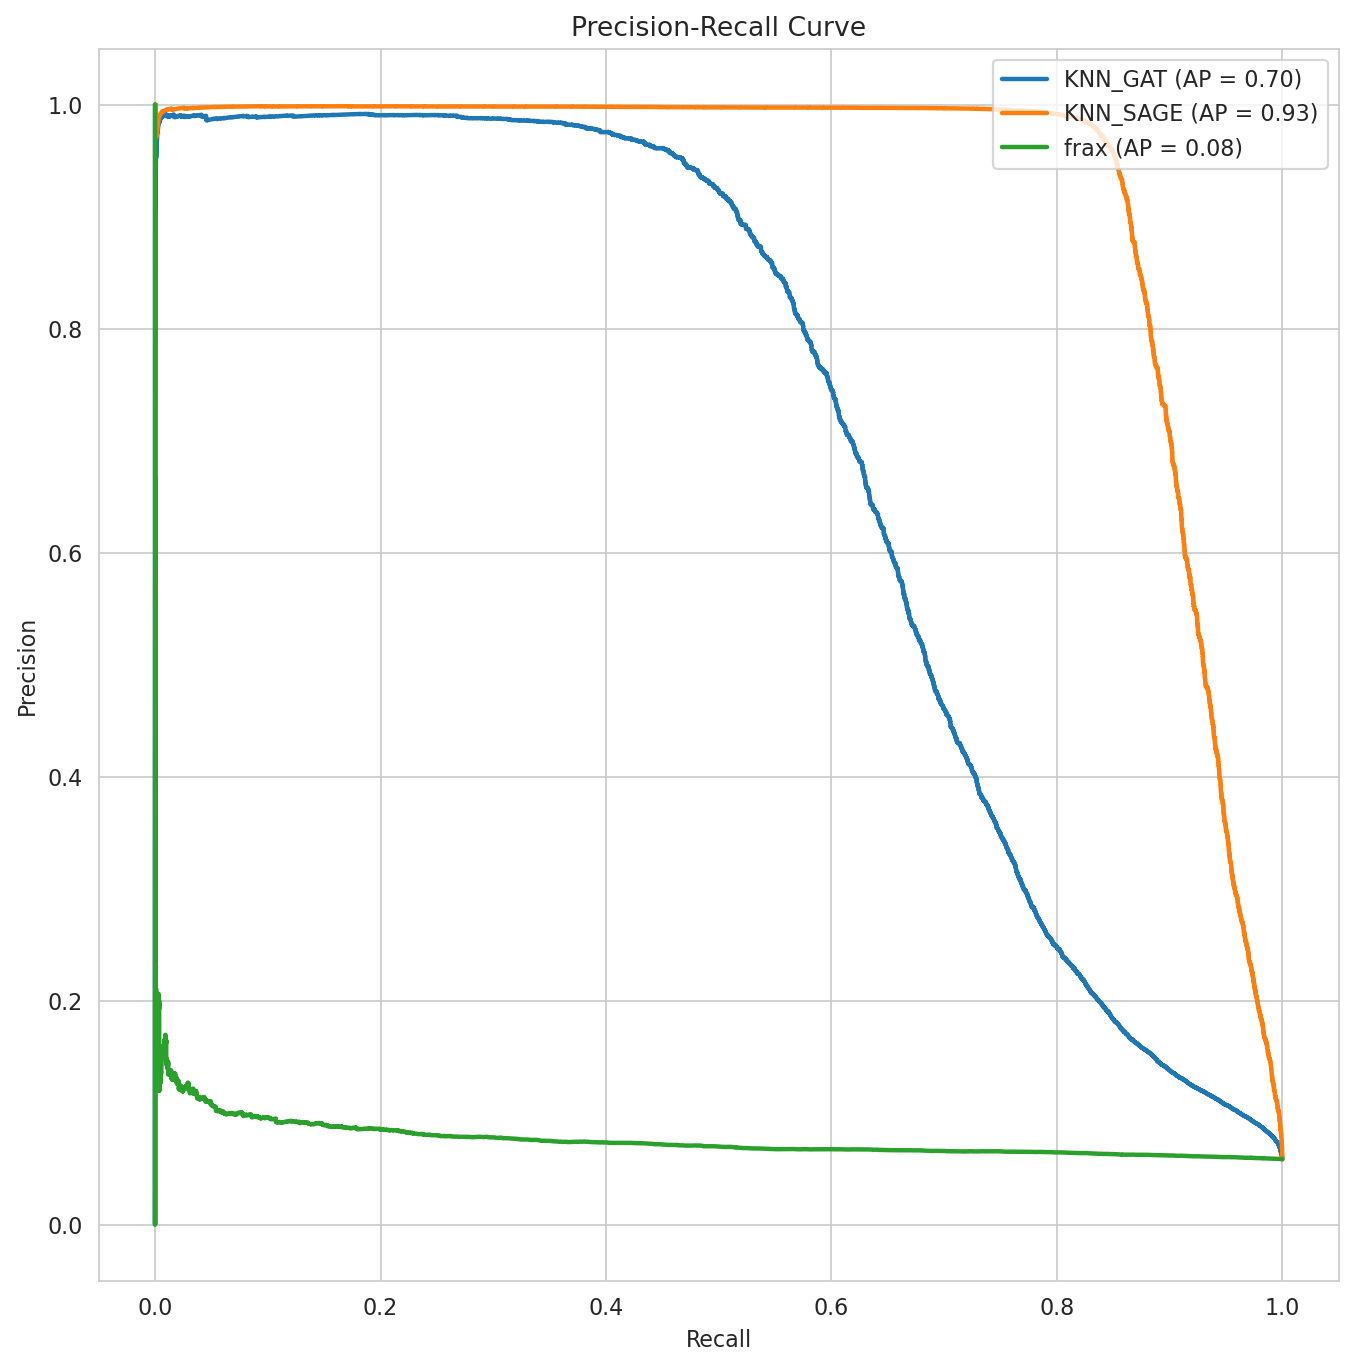

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Set the parent directory containing your .npy files
parent_dir = folder_to_analyze

# Automatically build the mapping of models to prediction and label files
data_files = {}

for file in os.listdir(parent_dir):
    if file.endswith('.npy'):
        full_path = os.path.join(parent_dir, file)
        # Identify label files: either start with "Y_" or end with "_Y.npy"
        if file.startswith('Y_'):
            model_key = file[2:-4]  # Remove 'Y_' prefix and '.npy'
            data_files.setdefault(model_key, {})['label'] = full_path
        elif file.endswith('_Y.npy'):
            model_key = file[:-6]  # Remove '_Y.npy'
            data_files.setdefault(model_key, {})['label'] = full_path
        else:
            # For prediction files: if it ends with '_all.npy', remove that part; else remove '.npy'
            if file.endswith('_all.npy'):
                model_key = file.replace('_all.npy', '')
            else:
                model_key = file[:-4]
            data_files.setdefault(model_key, {})['pred'] = full_path

# Optionally, print the detected mapping
print("Detected model files:")
for model, files in data_files.items():
    print(f"{model}: {files}")

# Plot ROC Curves
plt.figure(figsize=(10, 10), dpi = 160)
for model_name, files in data_files.items():
    if 'pred' in files and 'label' in files:
        y_pred = np.load(files['pred'])
        y_true = np.load(files['label'])
        
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
        
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Diagonal line for random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall Curves
plt.figure(figsize=(10, 10), dpi = 160)
for model_name, files in data_files.items():
    if 'pred' in files and 'label' in files:
        y_pred = np.load(files['pred'])
        y_true = np.load(files['label'])
        
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, lw=2, label=f'{model_name} (AP = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


## Sensitivity Analysis

In [22]:
!ls probs_cohort0

frax_all.npy  GAUSS_GAT.npy   KNN_GAT.npy   Y_GAUSS_GAT.npy   Y_KNN_GAT.npy
frax_Y.npy    GAUSS_SAGE.npy  KNN_SAGE.npy  Y_GAUSS_SAGE.npy  Y_KNN_SAGE.npy


In [42]:
parent_dir = "probs_cohortall"
y_true = np.load(parent_dir + '/frax_Y.npy')         # e.g., frax_Y.npy
y_pred_prob = np.load(parent_dir + '/frax_all.npy')  # e.g., frax_all.npy

FRAX

In [45]:
import numpy as np
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

import numpy as np
from sklearn.metrics import roc_auc_score

def compute_threshold_metrics(y_true, y_pred_prob, threshold):
    """
    Computes threshold-based metrics:
      - Sensitivity (TPR)
      - Specificity (TNR)
      - PPV (Precision)
    """
    # Generate binary predictions using the given threshold
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    TP = np.sum((y_pred == 1) & (y_true == 1))
    TN = np.sum((y_pred == 0) & (y_true == 0))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else np.nan
    specificity = TN / (TN + FP) if (TN + FP) > 0 else np.nan
    ppv = TP / (TP + FP) if (TP + FP) > 0 else np.nan
    return sensitivity, specificity, ppv

def bootstrap_metric(y_true, y_pred_prob, threshold, metric_index, n_bootstrap=100):
    """
    Bootstraps a single metric (by index from compute_threshold_metrics output)
    and returns (mean, lower_CI, upper_CI).
    """
    boot_metrics = []
    n = len(y_true)
    for _ in tqdm(range(n_bootstrap)):
        indices = np.random.choice(n, size=n, replace=True)
        boot_y_true = y_true[indices]
        boot_y_pred_prob = y_pred_prob[indices]
        metrics = compute_threshold_metrics(boot_y_true, boot_y_pred_prob, threshold)
        boot_metrics.append(metrics[metric_index])
    boot_metrics = np.array(boot_metrics)
    # Check if any values were computed
    if boot_metrics.size == 0:
        return np.nan, np.nan, np.nan
    lower = np.percentile(boot_metrics, 2.5)
    upper = np.percentile(boot_metrics, 97.5)
    mean_val = np.mean(boot_metrics)
    return mean_val, lower, upper

def bootstrap_auc(y_true, y_pred_prob, n_bootstrap=100):
    """
    Bootstraps AUC (using continuous predictions) and returns (mean, lower_CI, upper_CI).
    """
    boot_aucs = []
    n = len(y_true)
    for _ in tqdm(range(n_bootstrap)):
        indices = np.random.choice(n, size=n, replace=True)
        boot_y_true = y_true[indices]
        boot_y_pred_prob = y_pred_prob[indices]
        try:
            auc_val = roc_auc_score(boot_y_true, boot_y_pred_prob)
            boot_aucs.append(auc_val)
        except ValueError:
            # Occurs if only one class is present in the bootstrap sample.
            continue
    boot_aucs = np.array(boot_aucs)
    if boot_aucs.size == 0:
        return np.nan, np.nan, np.nan
    lower = np.percentile(boot_aucs, 2.5)
    upper = np.percentile(boot_aucs, 97.5)
    mean_val = np.mean(boot_aucs)
    return mean_val, lower, upper

# ------------------------------
# Example usage
# ------------------------------
# Replace these with your actual file paths or arrays.
# For example, load your data from .npy files:

# Define 5 thresholds between 0 and 0.5
thresholds = np.linspace(5, 30, 5)

results = {}

# Since AUC is threshold-independent, compute it once (via bootstrapping)
auc_mean, auc_lower, auc_upper = bootstrap_auc(y_true, y_pred_prob)

for threshold in thresholds:
    sens_mean, sens_lower, sens_upper = bootstrap_metric(y_true, y_pred_prob, threshold, metric_index=0)
    spec_mean, spec_lower, spec_upper = bootstrap_metric(y_true, y_pred_prob, threshold, metric_index=1)
    ppv_mean, ppv_lower, ppv_upper   = bootstrap_metric(y_true, y_pred_prob, threshold, metric_index=2)
    
    results[threshold] = {
        'Sensitivity': (sens_mean, sens_lower, sens_upper),
        'Specificity': (spec_mean, spec_lower, spec_upper),
        'PPV':         (ppv_mean, ppv_lower, ppv_upper),
        'AUC':         (auc_mean, auc_lower, auc_upper)
    }

# Print the results for each threshold
for thr, metrics in results.items():
    print(f"Threshold: {thr:.2f}")
    for metric_name, (mean_val, lower, upper) in metrics.items():
        print(f"  {metric_name}: Mean = {mean_val:.3f}, 95% CI = [{lower:.3f}, {upper:.3f}]")



  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 5.00
  Sensitivity: Mean = 0.751, 95% CI = [0.739, 0.764]
  Specificity: Mean = 0.333, 95% CI = [0.330, 0.337]
  PPV: Mean = 0.066, 95% CI = [0.064, 0.068]
  AUC: Mean = 0.566, 95% CI = [0.558, 0.573]
Threshold: 11.25
  Sensitivity: Mean = 0.188, 95% CI = [0.178, 0.199]
  Specificity: Mean = 0.876, 95% CI = [0.873, 0.878]
  PPV: Mean = 0.086, 95% CI = [0.081, 0.091]
  AUC: Mean = 0.566, 95% CI = [0.558, 0.573]
Threshold: 17.50
  Sensitivity: Mean = 0.039, 95% CI = [0.034, 0.044]
  Specificity: Mean = 0.981, 95% CI = [0.980, 0.982]
  PPV: Mean = 0.113, 95% CI = [0.097, 0.131]
  AUC: Mean = 0.566, 95% CI = [0.558, 0.573]
Threshold: 23.75
  Sensitivity: Mean = 0.018, 95% CI = [0.014, 0.021]
  Specificity: Mean = 0.993, 95% CI = [0.992, 0.993]
  PPV: Mean = 0.130, 95% CI = [0.102, 0.159]
  AUC: Mean = 0.566, 95% CI = [0.558, 0.573]
Threshold: 30.00
  Sensitivity: Mean = 0.006, 95% CI = [0.004, 0.008]
  Specificity: Mean = 0.998, 95% CI = [0.998, 0.998]
  PPV: Mean = 0.150, 95% C

## MODEL

In [47]:
!ls probs_cohortall

frax_all.npy  KNN_GAT.npy   Y_KNN_GAT.npy
frax_Y.npy    KNN_SAGE.npy  Y_KNN_SAGE.npy


In [48]:
parent_dir = "probs_cohortall"
y_true = np.load(parent_dir + '/Y_KNN_SAGE.npy')         # e.g., frax_Y.npy
y_pred_prob = np.load(parent_dir + '/KNN_SAGE.npy')  # e.g., frax_all.npy

In [49]:
import numpy as np
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

import numpy as np
from sklearn.metrics import roc_auc_score

def compute_threshold_metrics(y_true, y_pred_prob, threshold):
    """
    Computes threshold-based metrics:
      - Sensitivity (TPR)
      - Specificity (TNR)
      - PPV (Precision)
    """
    # Generate binary predictions using the given threshold
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    TP = np.sum((y_pred == 1) & (y_true == 1))
    TN = np.sum((y_pred == 0) & (y_true == 0))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else np.nan
    specificity = TN / (TN + FP) if (TN + FP) > 0 else np.nan
    ppv = TP / (TP + FP) if (TP + FP) > 0 else np.nan
    return sensitivity, specificity, ppv

def bootstrap_metric(y_true, y_pred_prob, threshold, metric_index, n_bootstrap=100):
    """
    Bootstraps a single metric (by index from compute_threshold_metrics output)
    and returns (mean, lower_CI, upper_CI).
    """
    boot_metrics = []
    n = len(y_true)
    for _ in tqdm(range(n_bootstrap)):
        indices = np.random.choice(n, size=n, replace=True)
        boot_y_true = y_true[indices]
        boot_y_pred_prob = y_pred_prob[indices]
        metrics = compute_threshold_metrics(boot_y_true, boot_y_pred_prob, threshold)
        boot_metrics.append(metrics[metric_index])
    boot_metrics = np.array(boot_metrics)
    # Check if any values were computed
    if boot_metrics.size == 0:
        return np.nan, np.nan, np.nan
    lower = np.percentile(boot_metrics, 2.5)
    upper = np.percentile(boot_metrics, 97.5)
    mean_val = np.mean(boot_metrics)
    return mean_val, lower, upper

def bootstrap_auc(y_true, y_pred_prob, n_bootstrap=100):
    """
    Bootstraps AUC (using continuous predictions) and returns (mean, lower_CI, upper_CI).
    """
    boot_aucs = []
    n = len(y_true)
    for _ in tqdm(range(n_bootstrap)):
        indices = np.random.choice(n, size=n, replace=True)
        boot_y_true = y_true[indices]
        boot_y_pred_prob = y_pred_prob[indices]
        try:
            auc_val = roc_auc_score(boot_y_true, boot_y_pred_prob)
            boot_aucs.append(auc_val)
        except ValueError:
            # Occurs if only one class is present in the bootstrap sample.
            continue
    boot_aucs = np.array(boot_aucs)
    if boot_aucs.size == 0:
        return np.nan, np.nan, np.nan
    lower = np.percentile(boot_aucs, 2.5)
    upper = np.percentile(boot_aucs, 97.5)
    mean_val = np.mean(boot_aucs)
    return mean_val, lower, upper

# ------------------------------
# Example usage
# ------------------------------
# Replace these with your actual file paths or arrays.
# For example, load your data from .npy files:

# Define 5 thresholds between 0 and 0.5
thresholds = np.linspace(0.05, 0.3, 5)

results = {}

# Since AUC is threshold-independent, compute it once (via bootstrapping)
auc_mean, auc_lower, auc_upper = bootstrap_auc(y_true, y_pred_prob)

for threshold in thresholds:
    sens_mean, sens_lower, sens_upper = bootstrap_metric(y_true, y_pred_prob, threshold, metric_index=0)
    spec_mean, spec_lower, spec_upper = bootstrap_metric(y_true, y_pred_prob, threshold, metric_index=1)
    ppv_mean, ppv_lower, ppv_upper   = bootstrap_metric(y_true, y_pred_prob, threshold, metric_index=2)
    
    results[threshold] = {
        'Sensitivity': (sens_mean, sens_lower, sens_upper),
        'Specificity': (spec_mean, spec_lower, spec_upper),
        'PPV':         (ppv_mean, ppv_lower, ppv_upper),
        'AUC':         (auc_mean, auc_lower, auc_upper)
    }

# Print the results for each threshold
for thr, metrics in results.items():
    print(f"Threshold: {thr:.2f}")
    for metric_name, (mean_val, lower, upper) in metrics.items():
        print(f"  {metric_name}: Mean = {mean_val:.3f}, 95% CI = [{lower:.3f}, {upper:.3f}]")



  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.05
  Sensitivity: Mean = 0.998, 95% CI = [0.998, 0.998]
  Specificity: Mean = 0.356, 95% CI = [0.355, 0.356]
  PPV: Mean = 0.087, 95% CI = [0.087, 0.088]
  AUC: Mean = 0.983, 95% CI = [0.983, 0.983]
Threshold: 0.11
  Sensitivity: Mean = 0.976, 95% CI = [0.976, 0.977]
  Specificity: Mean = 0.769, 95% CI = [0.768, 0.769]
  PPV: Mean = 0.207, 95% CI = [0.206, 0.208]
  AUC: Mean = 0.983, 95% CI = [0.983, 0.983]
Threshold: 0.17
  Sensitivity: Mean = 0.931, 95% CI = [0.930, 0.933]
  Specificity: Mean = 0.941, 95% CI = [0.941, 0.941]
  PPV: Mean = 0.493, 95% CI = [0.491, 0.495]
  AUC: Mean = 0.983, 95% CI = [0.983, 0.983]
Threshold: 0.24
  Sensitivity: Mean = 0.899, 95% CI = [0.898, 0.901]
  Specificity: Mean = 0.977, 95% CI = [0.977, 0.977]
  PPV: Mean = 0.710, 95% CI = [0.708, 0.712]
  AUC: Mean = 0.983, 95% CI = [0.983, 0.983]
Threshold: 0.30
  Sensitivity: Mean = 0.872, 95% CI = [0.870, 0.873]
  Specificity: Mean = 0.991, 95% CI = [0.991, 0.991]
  PPV: Mean = 0.857, 95% CI = 